In [4]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# --- Match your training setup ---
IN_CH = 1           # 1 if grayscale
NUM_CLASSES = 2     # change if different
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Corrected path (one level up from notebooks/)
WEIGHTS_PATH = "../weights/densenet169_clean.pth"
TEST_DIR = "../../chest_xray/test"   # adjust if your test folder is elsewhere
# ---------------------------------

# 🔍 Verify files exist
print("Current working directory:", Path.cwd())
print("Weights exist:", Path(WEIGHTS_PATH).exists())
print("Test dir exists:", Path(TEST_DIR).exists())

# 1️⃣ Recreate your model
model = models.densenet169(weights=None)
if IN_CH == 1:
    old = model.features.conv0
    model.features.conv0 = nn.Conv2d(
        1, old.out_channels,
        kernel_size=old.kernel_size,
        stride=old.stride,
        padding=old.padding,
        bias=False
    )
model.classifier = nn.Linear(model.classifier.in_features, NUM_CLASSES)

# 2️⃣ Load weights
state = torch.load(WEIGHTS_PATH, map_location=DEVICE)
model.load_state_dict(state)
model = model.to(DEVICE).eval()

# 3️⃣ Load test data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.481], [0.223])
])

test_data = datasets.ImageFolder(TEST_DIR, transform=transform)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print("✅ Model and test data loaded successfully!")
print(f"Found {len(test_data)} test images across {len(test_data.classes)} classes: {test_data.classes}")


Current working directory: c:\Users\rishab\chest_xray_classification\Medical-Image-Classification\notebooks
Weights exist: True
Test dir exists: True
✅ Model and test data loaded successfully!
Found 624 test images across 2 classes: ['NORMAL', 'PNEUMONIA']


In [6]:
# === Inference on test data ===
import numpy as np
import torch
from tqdm.auto import tqdm

all_preds, all_labels = [], []

model.eval()
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Running inference"):
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        logits = model(imgs)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("✅ Inference complete.")
print(f"Total samples predicted: {len(all_preds)}")


Running inference:   0%|          | 0/20 [00:00<?, ?it/s]

✅ Inference complete.
Total samples predicted: 624


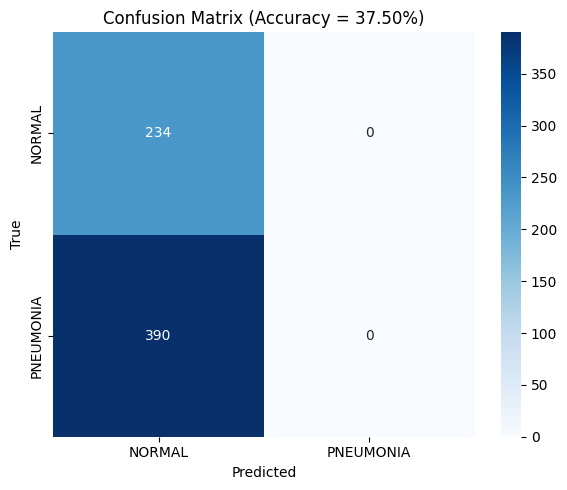

📊 Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.3750    1.0000    0.5455       234
   PNEUMONIA     0.0000    0.0000    0.0000       390

    accuracy                         0.3750       624
   macro avg     0.1875    0.5000    0.2727       624
weighted avg     0.1406    0.3750    0.2045       624



c:\Users\rishab\chest_xray_classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\rishab\chest_xray_classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\rishab\chest_xray_classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

In [7]:
# === Confusion Matrix + Precision / Recall / F1 ===
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Convert to NumPy (safety)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
classes = test_data.classes  # e.g. ['NORMAL', 'PNEUMONIA']

# --- Accuracy ---
acc = accuracy_score(all_labels, all_preds) * 100

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title(f"Confusion Matrix (Accuracy = {acc:.2f}%)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# --- Precision, Recall, F1 ---
print("📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes, digits=4))


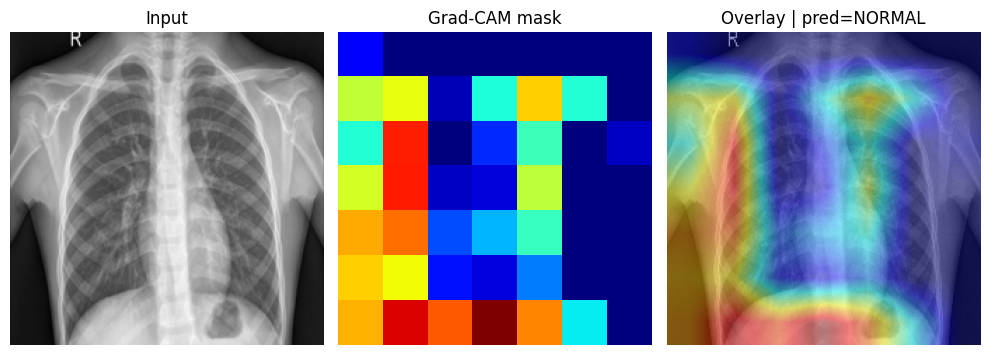

✅ Grad-CAM saved at: C:\Users\rishab\chest_xray_classification\Medical-Image-Classification\notebooks\gradcam_output.jpg


In [8]:
# ---------------------------------------------
# Grad-CAM (teacher-style) for DenseNet-169
# ---------------------------------------------
import torch, torch.nn as nn, torch.nn.functional as F
import numpy as np, matplotlib.pyplot as plt, cv2
from PIL import Image
from torchvision import transforms
from pathlib import Path

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------------------------
# Preprocess input image (grayscale X-ray)
# ---------------------------------------------
def preprocess_image(img_path):
    img = Image.open(img_path).convert('L')  # grayscale
    img = img.resize((224, 224))
    transform = transforms.Compose([
        transforms.ToTensor(),
        # use the SAME mean/std you trained with (you used ~0.481/0.223)
        transforms.Normalize(mean=[0.481], std=[0.223]),
    ])
    img_tensor = transform(img).unsqueeze(0)  # [1, 1, 224, 224]
    return img_tensor.to(DEVICE)

# ---------------------------------------------
# Get class label from prediction
# ---------------------------------------------
def get_class_label(output):
    _, predicted = torch.max(output, 1)
    return predicted.item()

# ---------------------------------------------
# Access nested layers in model by name
# e.g. "features.denseblock4.denselayer32.conv2"
# ---------------------------------------------
def get_conv_layer(model, layer_name):
    layer = model
    for attr in layer_name.split("."):
        if attr.isdigit():
            layer = layer[int(attr)]
        else:
            layer = getattr(layer, attr)
    return layer

# ---------------------------------------------
# Compute Grad-CAM
# Default layer is the final 3x3 conv in DenseNet-169
# ---------------------------------------------
def compute_gradcam(model, img_tensor, class_index,
                    conv_layer_name="features.denseblock4.denselayer32.conv2"):
    model.eval()
    conv_layer = get_conv_layer(model, conv_layer_name)

    activations, gradients = [], []

    def forward_hook(module, inp, out):
        activations.append(out)

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])  # dL/d(activations)

    f_hook = conv_layer.register_forward_hook(forward_hook)
    b_hook = conv_layer.register_full_backward_hook(backward_hook)

    # Forward + backward
    output = model(img_tensor)                  # [1, num_classes]
    score = output[:, class_index]              # scalar for target class
    model.zero_grad(set_to_none=True)
    score.backward()

    # Remove hooks
    f_hook.remove()
    b_hook.remove()

    # Build CAM
    act = activations[0].squeeze(0)            # [C,H,W]
    grad = gradients[0].squeeze(0)             # [C,H,W]
    weights = grad.mean(dim=(1, 2))            # [C]

    cam = torch.zeros_like(act[0])
    for i, w in enumerate(weights):
        cam += w * act[i]

    cam = cam.detach().cpu().numpy()
    cam = np.maximum(cam, 0)
    cam /= (cam.max() + 1e-8)
    return cam

# ---------------------------------------------
# Overlay heatmap on original image
# ---------------------------------------------
def overlay_heatmap(img_path, heatmap, alpha=0.45):
    base = cv2.imread(img_path)                 # BGR
    base = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
    base = cv2.resize(base, (224, 224))
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap_u8 = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap_u8, cv2.COLORMAP_JET)  # BGR
    overlay = alpha * heatmap_color + (1 - alpha) * cv2.cvtColor(base, cv2.COLOR_GRAY2BGR)
    overlay = np.clip(overlay, 0, 255).astype(np.uint8)
    return overlay  # BGR

# ---------------------------------------------
# Main block (pick an image; or set IMG_PATH)
# ---------------------------------------------
# Use first test sample if available; else set manual path.
try:
    IMG_PATH, true_label = test_data.samples[0]
except Exception:
    IMG_PATH = "../../chest_xray/test/NORMAL/IM-0001-0001.jpeg"  # <-- change if needed

img_tensor = preprocess_image(IMG_PATH)

# Predict class
with torch.no_grad():
    logits = model(img_tensor)
pred_idx = get_class_label(logits)

# Generate Grad-CAM (DenseNet last conv by default)
cam = compute_gradcam(
    model,
    img_tensor,
    class_index=pred_idx,
    conv_layer_name="features.denseblock4.denselayer32.conv2"
)

# Overlay, save, and display
overlay_bgr = overlay_heatmap(IMG_PATH, cam, alpha=0.45)
save_path = Path("./gradcam_output.jpg")
cv2.imwrite(str(save_path), overlay_bgr)  # saved in notebooks/ (current CWD)

# Show inline (convert BGR->RGB for matplotlib)
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1); plt.imshow(Image.open(IMG_PATH).convert('L').resize((224,224)), cmap='gray'); plt.axis('off'); plt.title("Input")
plt.subplot(1, 3, 2); plt.imshow(cam, cmap='jet'); plt.axis('off'); plt.title("Grad-CAM mask")
plt.subplot(1, 3, 3); plt.imshow(overlay_bgr[:, :, ::-1]); plt.axis('off'); plt.title(f"Overlay | pred={test_data.classes[pred_idx] if 'test_data' in globals() else pred_idx}")
plt.tight_layout(); plt.show()

print(f"✅ Grad-CAM saved at: {save_path.resolve()}")
